# Hierarchical DivNoising - Prediction
This notebook contains an example on how to use a previously trained Hierarchical DivNoising model to denoise images.
If you haven't done so please first run '1-CreateNoiseModel.ipynb' and '2-Training.ipynb' notebooks.

In [1]:
# We import all our dependencies.
import math
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer

import sys
sys.path.append('../../../../')

from models.lvae import LadderVAE
from boilerplate import boilerplate
import lib.utils as utils
import training

import os
import glob
import zipfile
import urllib
from tifffile import imread, imsave
from matplotlib import pyplot as plt
from tqdm import tqdm
from skimage.util import view_as_windows

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Load noisy test data
The GT test data (```signal```) is created by averaging the noisy images (```observations```).

Shape of validation images: (100, 1024, 1024)


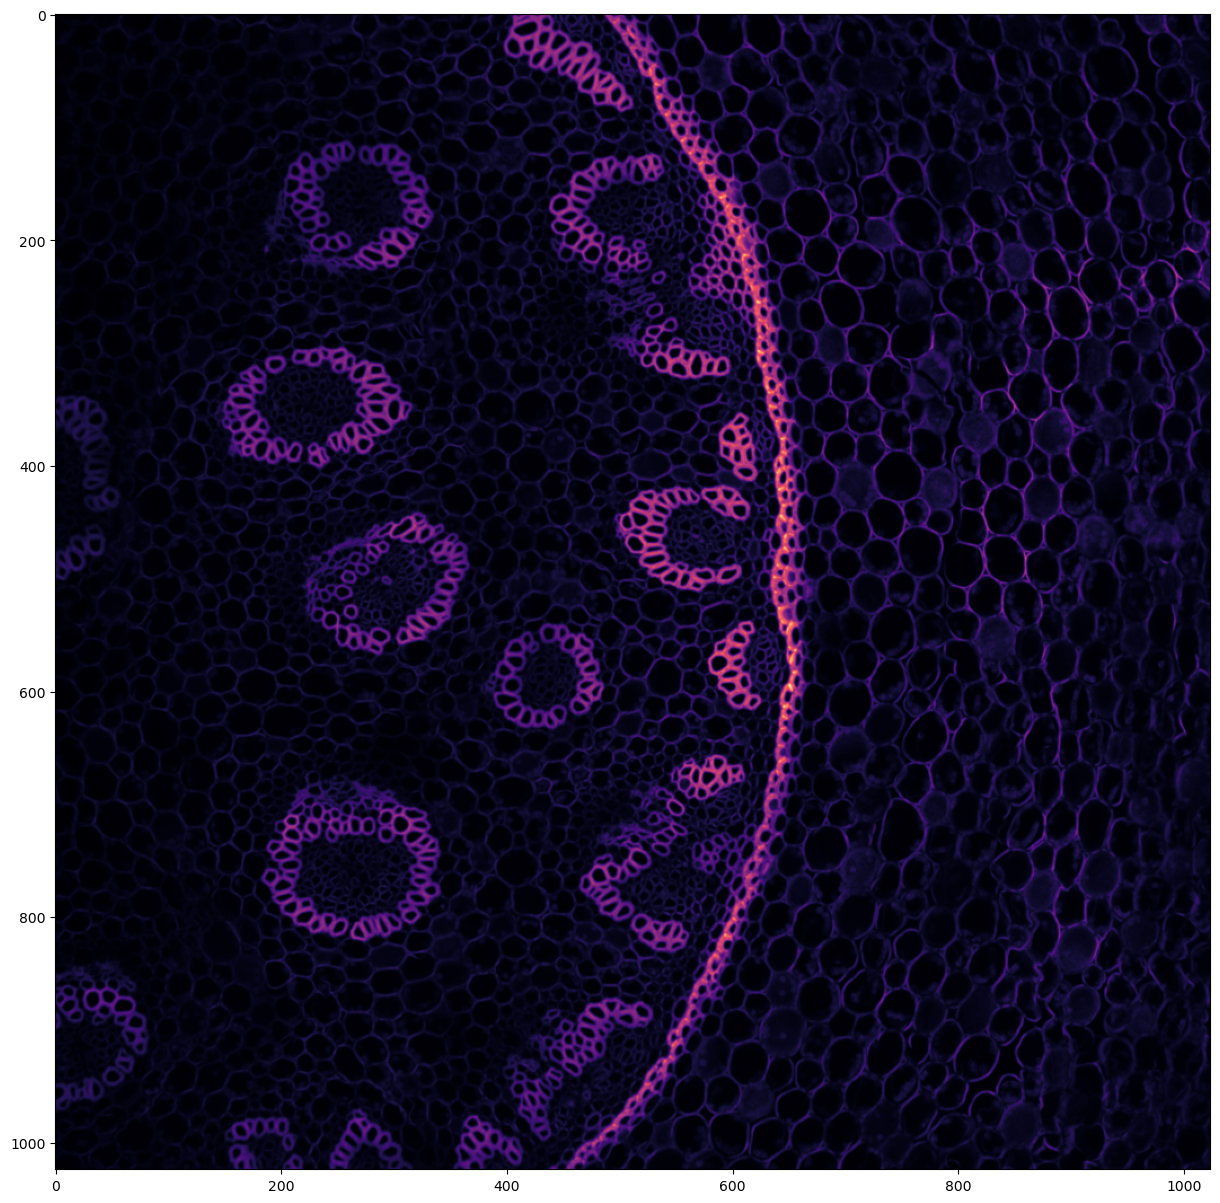

In [3]:
path = "./data/Convallaria_diaphragm/"

# The test data is just one quater of the full image ([:,:512,:512]) following the works which have used this data earlier
observation = imread(path+'20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif').astype(np.float32)[:,:, :]
signal = np.mean(observation[:,...],axis=0)[np.newaxis,...]
img_width, img_height = signal.shape[1], signal.shape[2]

print("Shape of validation images:", observation.shape)
plt.figure(figsize=(15, 15))
plt.imshow(signal[0], cmap='magma')

# Load our model

In [4]:
%%capture
model = torch.load("./Trained_model/model/mouse_test_cp_nd_last_vae.net")
model.mode_pred=True
model.eval()

# Compute PSNR
The higher the PSNR, the better the denoising performance is.
PSNR is computed using the formula: 

```PSNR = 20 * log(rangePSNR) - 10 * log(mse)``` <br> 
where ```mse = mean((gt - img)**2)```, ```gt``` is ground truth image and ```img``` is the prediction from HDN. All logarithms are with base 10.<br>
rangePSNR = max(```gt```)-min(```gt```) for as used in this [paper](https://ieeexplore.ieee.org/abstract/document/9098612/).

In [ ]:
gaussian_noise_std = None
num_samples = 1 # number of samples used to compute MMSE estimate
tta = False # turn on test time augmentation when set to True. It may improve performance at the expense of 8x longer prediction time
psnrs = []
range_psnr = np.max(signal[0])-np.min(signal[0])
for i in range(observation.shape[0])[:10]:
    img_mmse, samples = boilerplate.predict(observation[i],num_samples,model,gaussian_noise_std,device,tta)
    psnr = utils.PSNR(signal[0], img_mmse, range_psnr)
    psnrs.append(psnr)
    print("image:", i, "PSNR:", psnr, "Mean PSNR:", np.mean(psnrs))


In [10]:
ps = 600
overlap = 512
assert ps > overlap

num_samples = 10
tta = False
gaussian_noise_std = None
im = observation[0]

xmin = 0
ymin = 0 
xmax = ps
ymax = ps
ovLeft = 0
pred = np.zeros(im.shape)
tiles = []
crops = []
coords = []


while xmin < im.shape[1]:
    ovTop = 0
    while ymin < im.shape[0]:
        ymin_ = min(im.shape[0], ymax) - ps
        xmin_ = min(im.shape[1], xmax) - ps
        lastPatchShiftY = ymin - ymin_
        lastPatchShiftX = xmin - xmin_  
        if ((ymin_, ymax), (xmin_, xmax)) not in coords:
            coords.append(((ymin_, ymax), (xmin_, xmax)))
            img_mmse, samples = boilerplate.predict(im[ymin_:ymax,xmin_:xmax], 
                                                num_samples,
                                                model,
                                                gaussian_noise_std,
                                                device,
                                                tta)

            pred[ymin:ymax,xmin:xmax][ovTop:,ovLeft:] = img_mmse[lastPatchShiftY:,lastPatchShiftX:][ovTop:,ovLeft:]
            tiles.append(im[ymin_:ymax,xmin_:xmax])

        crops.append(pred[ymin:ymax,xmin:xmax][ovTop:,ovLeft:])
        ymin=ymin-overlap+ps
        ymax=min(im.shape[0], ymin+ps)
        ovTop=overlap//2

    ymin=0
    ymax=ps
    xmin=xmin-overlap+ps
    xmax=min(im.shape[1], xmin+ps)
    ovLeft=overlap//2


tiles = np.stack(tiles)
crops = [crop for crop in crops if all(crop.shape) > 0]



N ((0, 600), (0, 600))
SH N (600, 600) (600, 600)
N ((88, 688), (0, 600))
SH N (600, 600) (344, 600)
N ((176, 776), (0, 600))
SH N (600, 600) (344, 600)
N ((264, 864), (0, 600))
SH N (600, 600) (344, 600)
N ((352, 952), (0, 600))
SH N (600, 600) (344, 600)
N ((424, 1024), (0, 600))
SH N (600, 600) (328, 600)
Y ((424, 1024), (0, 600))
Y ((424, 1024), (0, 600))
Y ((424, 1024), (0, 600))
Y ((424, 1024), (0, 600))
Y ((424, 1024), (0, 600))
Y ((424, 1024), (0, 600))
N ((0, 600), (88, 688))
SH N (600, 600) (600, 344)
N ((88, 688), (88, 688))
SH N (600, 600) (344, 344)
N ((176, 776), (88, 688))
SH N (600, 600) (344, 344)
N ((264, 864), (88, 688))
SH N (600, 600) (344, 344)
N ((352, 952), (88, 688))
SH N (600, 600) (344, 344)
N ((424, 1024), (88, 688))
SH N (600, 600) (328, 344)
Y ((424, 1024), (88, 688))
Y ((424, 1024), (88, 688))
Y ((424, 1024), (88, 688))
Y ((424, 1024), (88, 688))
Y ((424, 1024), (88, 688))
Y ((424, 1024), (88, 688))
N ((0, 600), (176, 776))
SH N (600, 600) (600, 344)
N ((

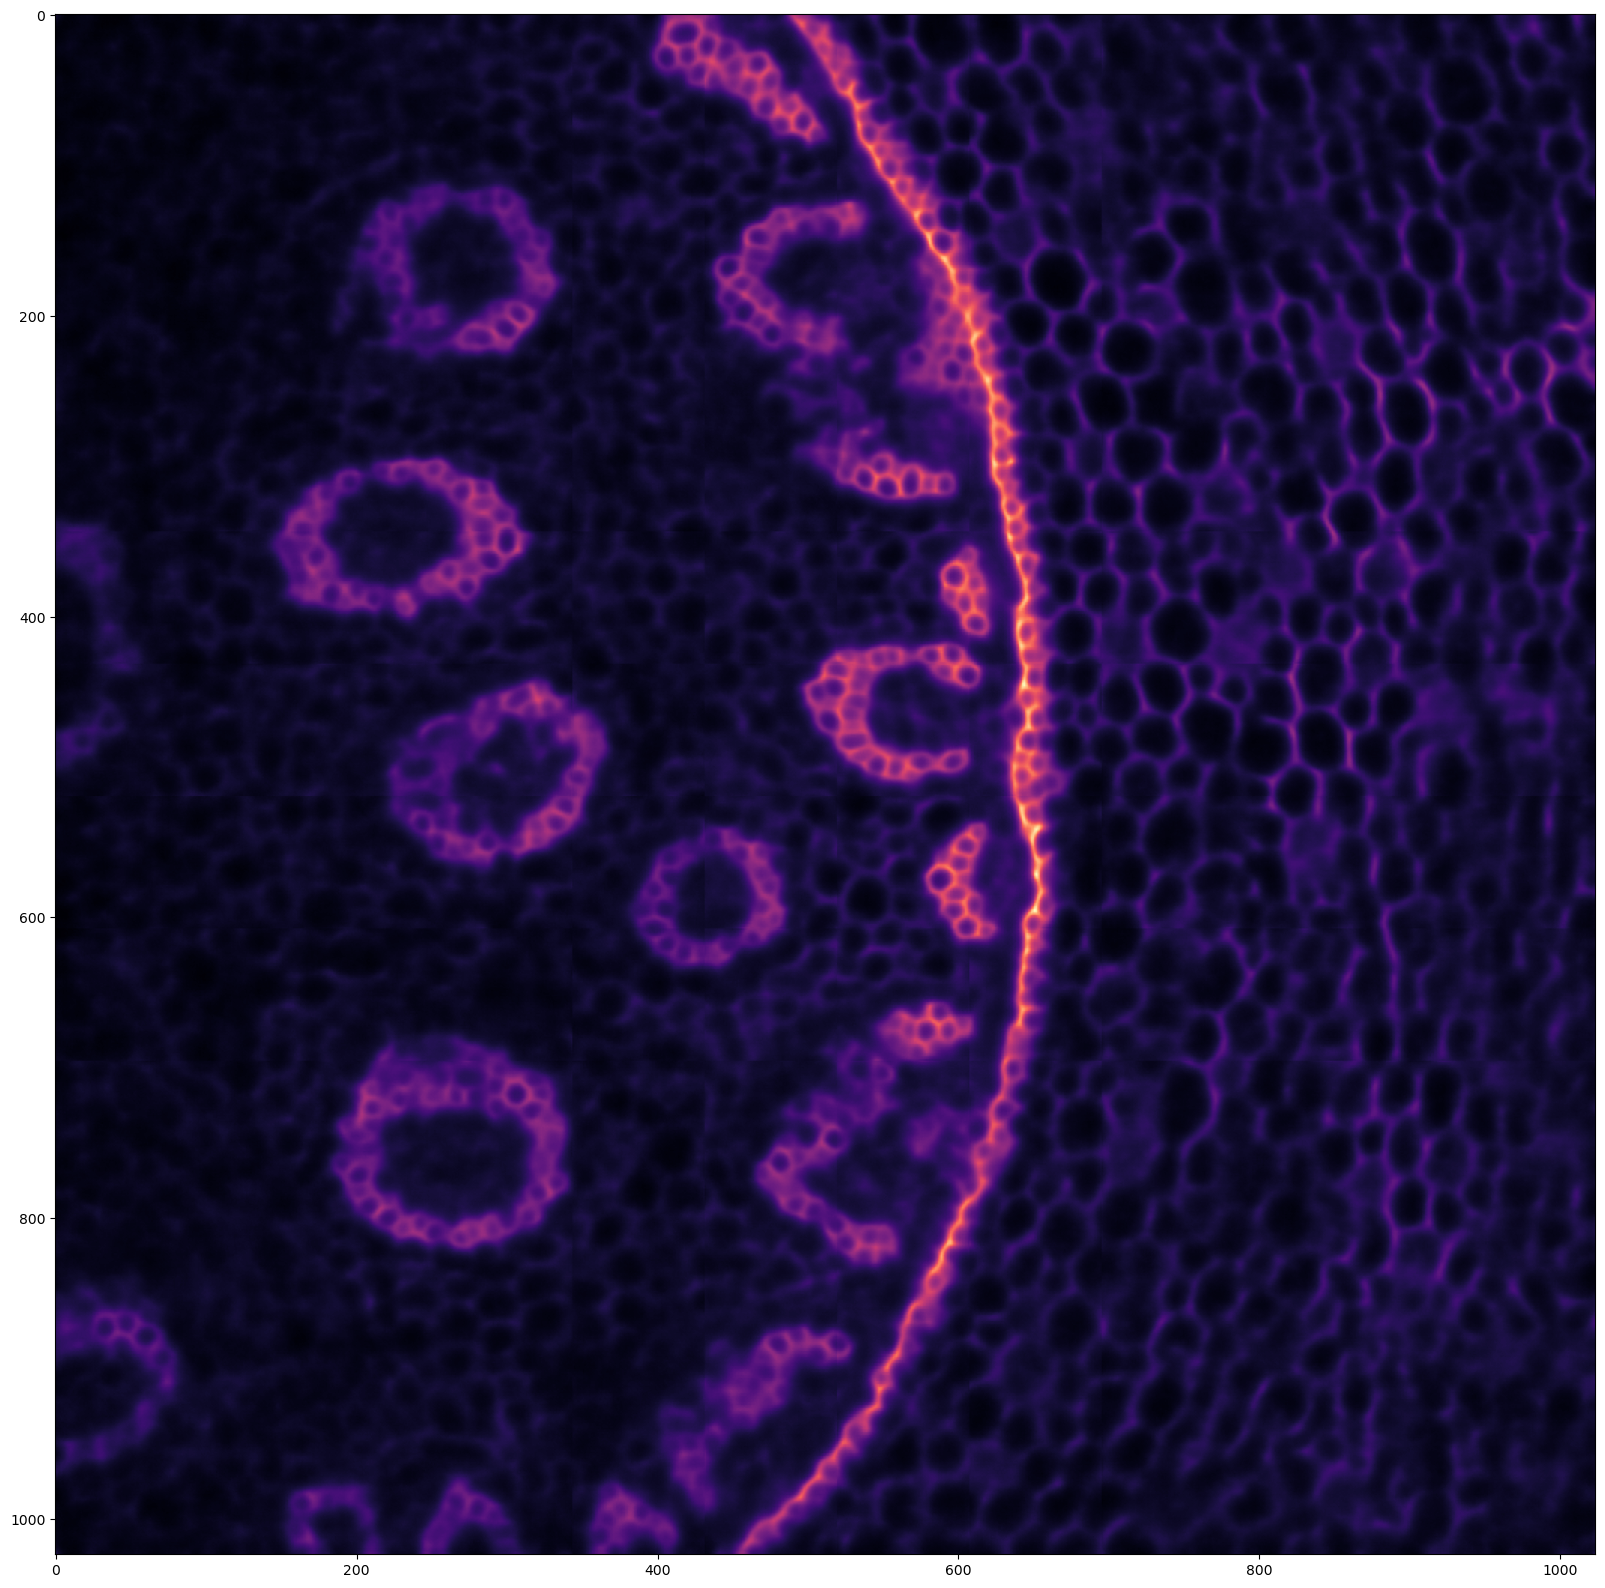

In [11]:
plt.figure(figsize=(20,20))
plt.imshow(pred, cmap='magma')
plt.show()

# Here we look at some qualitative solutions

455.8699951171875 780.3429284667969


IndexError: list index out of range

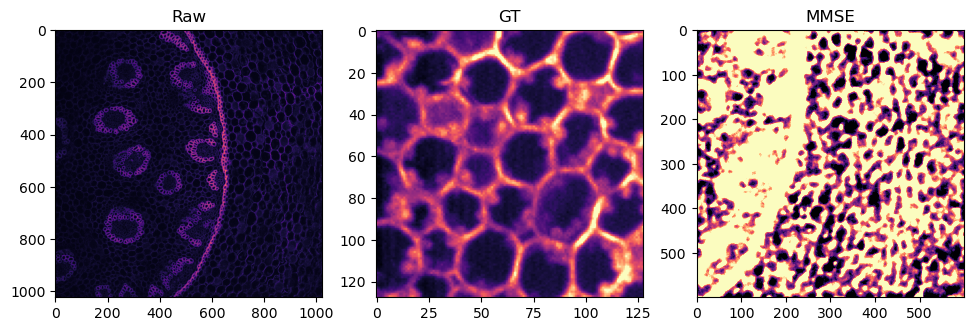

In [9]:
fig=plt.figure(figsize=(20, 10))
gt = signal[0][:128,:128]
vmin=np.percentile(gt,0)
vmax=np.percentile(gt,99)

print(vmin, vmax)

columns = 5
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(observation[-1][:,:],cmap='magma')
plt.title("Raw")
fig.add_subplot(rows, columns, 2)
plt.imshow(gt,vmin=vmin, vmax=vmax,cmap='magma')
plt.title("GT")
fig.add_subplot(rows, columns, 3)
plt.imshow(img_mmse[:,:],vmin=vmin, vmax=vmax,cmap='magma')
plt.title("MMSE")
for i in range(4, columns*rows+1):
    img = samples[i][:,:]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,vmin=vmin, vmax=vmax,cmap='magma')
    plt.title("Sample "+str(i-4))
plt.show()